In [1]:
PATH = "data/oranges/"

In [2]:
import os
from torchvision import datasets, models, transforms
import numpy as np
import time
import copy
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
import torch.nn.functional as F
from src.ploting import *
import PIL
%matplotlib inline

os.listdir(PATH)

['train', 'val']

In [3]:
os.listdir(f'{PATH}val')

['ripe', 'unripe']

In [4]:
files = os.listdir(f'{PATH}val/ripe')[:5]
files

['DSC_0255.JPG',
 'DSC_0256.JPG',
 'DSC_0257.JPG',
 'DSC_0258.JPG',
 'DSC_0259.JPG']

In [5]:
from PIL import Image
image = Image.open(f'{PATH}val/ripe/{files[0]}')
image.show()

In [6]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [7]:
image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),transform[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) 
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

['ripe', 'unripe']


In [8]:
def inverse_transform(inp):
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    return inp

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inverse_transform(inp)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=10)
    plt.axis('off')

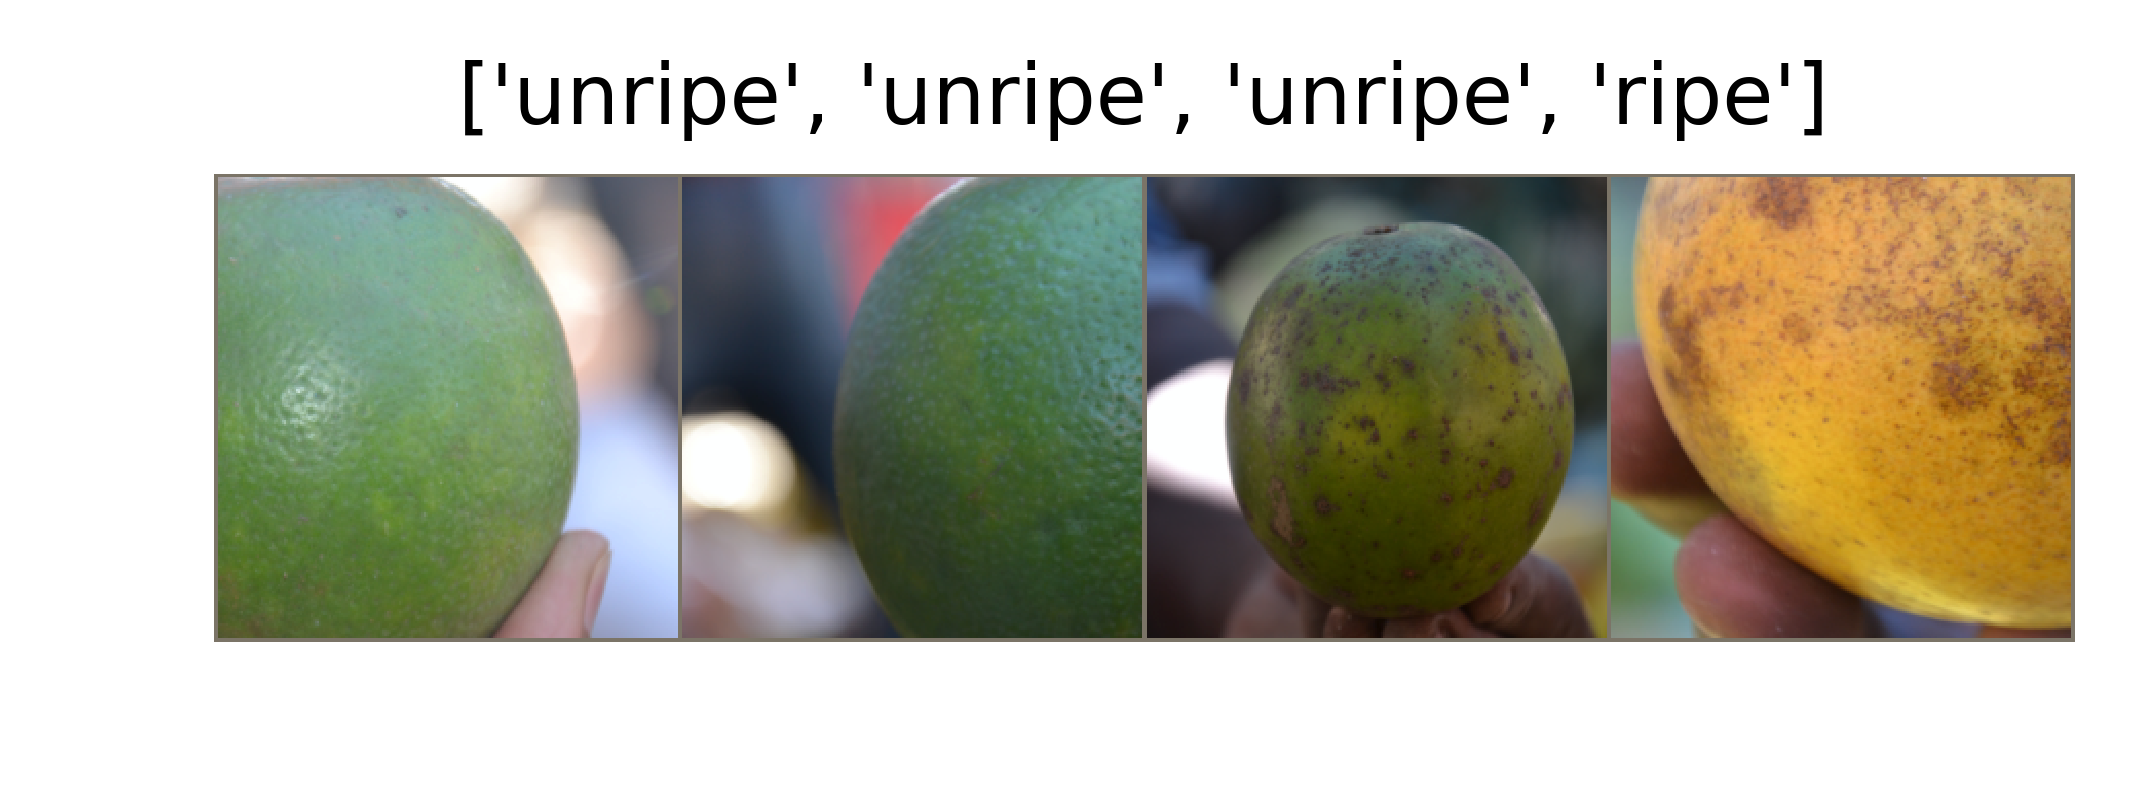

In [10]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

beatify(fig_width=4)
imshow(out, title=[class_names[x] for x in classes])

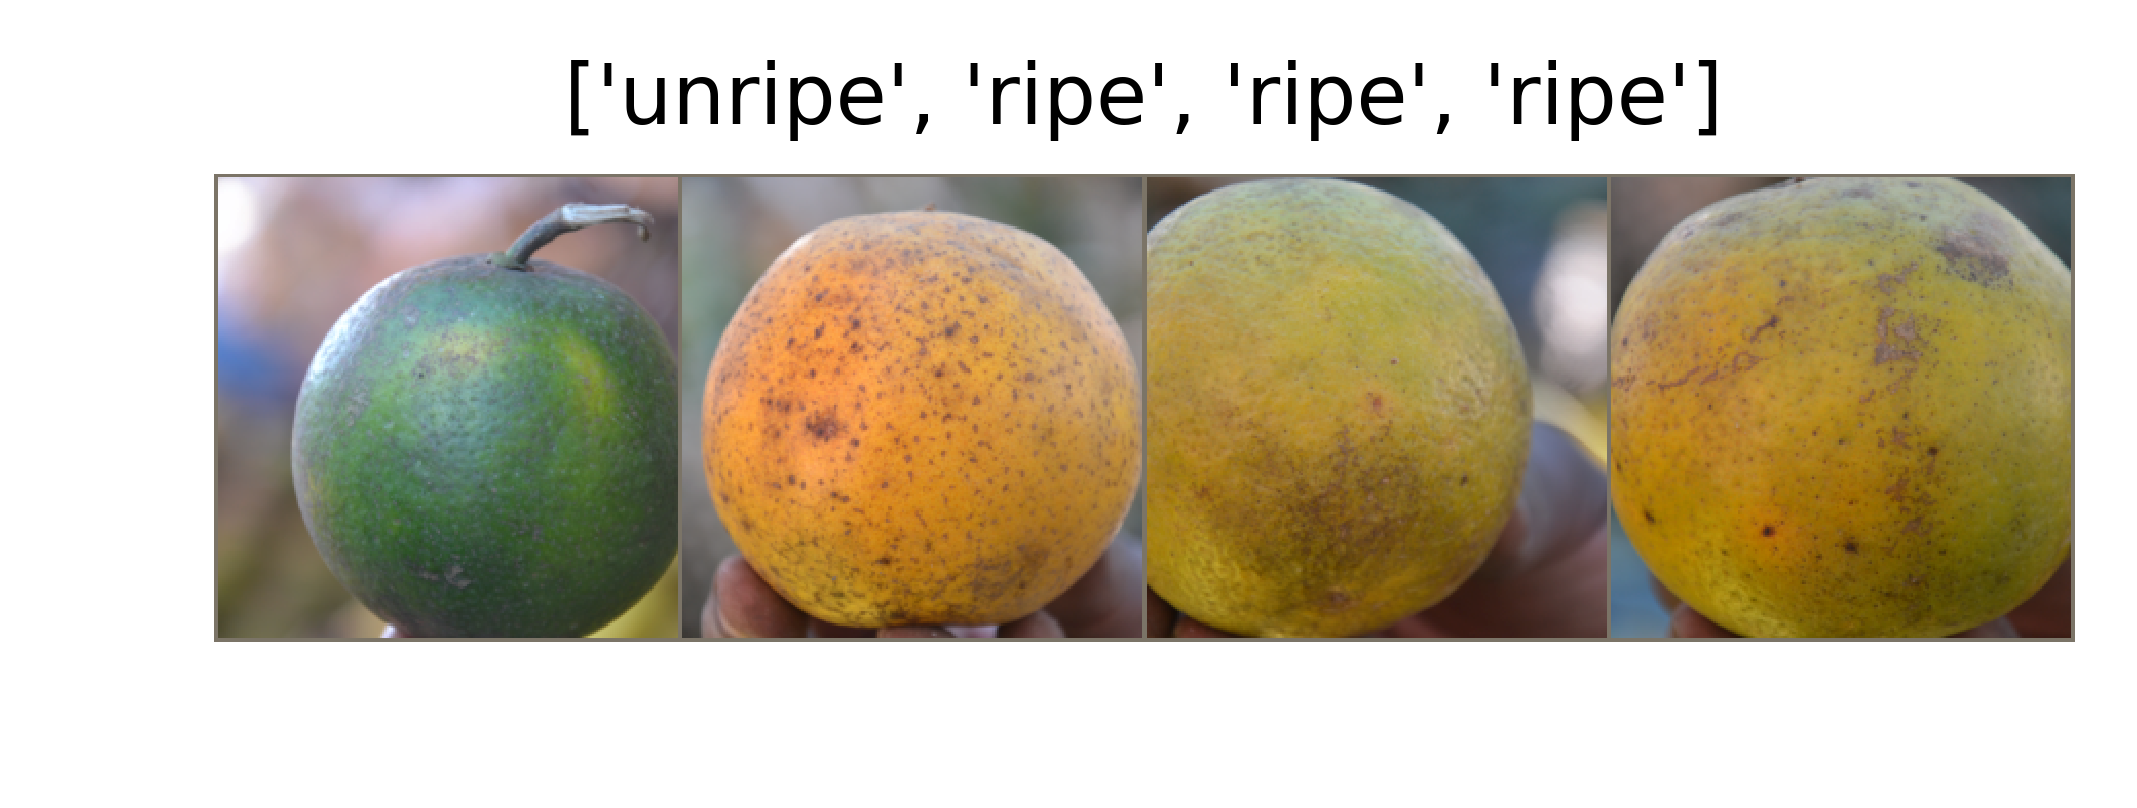

In [11]:
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

beatify(fig_width=4)
imshow(out, title=[class_names[x] for x in classes])

In [12]:
model_resnet18 = models.resnet18(pretrained=True)
print(model_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [13]:
# get number of feature from the final FC layer
num_features = model_resnet18.fc.in_features

In [14]:
#define FC layer with two output category
model_resnet18.fc = nn.Linear(num_features, 2)

In [15]:
print(model_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [16]:
criterion = nn.CrossEntropyLoss()

In [17]:
optimizer_rst18 = torch.optim.SGD(model_resnet18.parameters(), lr=0.001, momentum=0.9)

In [18]:
from torch.optim import lr_scheduler
# Decay LR by a factor of 0.1 every 2 epochs
scheduler_lr = lr_scheduler.StepLR(optimizer_rst18 , step_size=5)

In [19]:
def fit_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                #if torch.cuda.is_available():
                  #  inputs = Variable(inputs.cuda())
                   # labels = Variable(labels.cuda())
                #else:
                inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [20]:
model_best = fit_model(model_resnet18, criterion, optimizer_rst18,  scheduler_lr, dataloaders, num_epochs=10)

Epoch 1/10
----------


C:\Users\Apix\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


train Loss: 0.3698 Acc: 0.0000
val Loss: 0.0355 Acc: 1.0000

Epoch 2/10
----------
train Loss: 0.2483 Acc: 0.0000
val Loss: 0.0395 Acc: 0.0000

Epoch 3/10
----------
train Loss: 0.1343 Acc: 0.0000
val Loss: 0.0556 Acc: 0.0000

Epoch 4/10
----------
train Loss: 0.3337 Acc: 0.0000
val Loss: 0.0411 Acc: 1.0000

Epoch 5/10
----------
train Loss: 0.3285 Acc: 0.0000
val Loss: 0.0672 Acc: 0.0000

Epoch 6/10
----------
train Loss: 0.1166 Acc: 0.0000
val Loss: 0.0516 Acc: 0.0000

Epoch 7/10
----------
train Loss: 0.1090 Acc: 0.0000
val Loss: 0.0505 Acc: 0.0000

Epoch 8/10
----------
train Loss: 0.0748 Acc: 0.0000
val Loss: 0.0434 Acc: 1.0000

Epoch 9/10
----------
train Loss: 0.1295 Acc: 0.0000
val Loss: 0.0409 Acc: 1.0000

Epoch 10/10
----------
train Loss: 0.1957 Acc: 0.0000
val Loss: 0.0427 Acc: 1.0000

Training complete in 21m 31s
Best val Acc: 1.000000


In [21]:
def visualize_model(model, num_images=6):
    
    training_mode = model.training
    model.eval()
    images_so_far = 0
    

    for i, data in enumerate(dataloaders['val']):
        
        inputs, labels = data
        
        #if torch.cuda.is_available():
            #inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        #else:
        inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            plt.subplot(2, int(num_images/2), images_so_far)
            plt.imshow(inverse_transform(inputs.cpu().data[j]))
            plt.title('predicted: {}'.format(class_names[preds[j]]), fontsize=8)
            plt.tight_layout()
            plt.xticks([])
            plt.yticks([])
            #ax.axis('off')
    
            if images_so_far == num_images:
                model.train(mode=training_mode)
                return
    model.train(mode=training_mode)

In [22]:
model_resnet18_conv = models.resnet18(pretrained=True)
for param in model_resnet18_conv.parameters():
    param.requires_grad = False

In [23]:
num_feature = model_resnet18_conv.fc.in_features
model_resnet18_conv.fc = nn.Linear(num_feature, 2)

In [24]:
criterion = nn.CrossEntropyLoss()

In [25]:
optimizer_rst18_conve = torch.optim.SGD(model_resnet18_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [26]:
#Define schedule
scheduler_lr_conv = lr_scheduler.StepLR(optimizer_rst18_conve, step_size=5)

In [27]:
model_best_conv = fit_model(model_resnet18_conv, criterion, optimizer_rst18_conve, scheduler_lr_conv, dataloaders, num_epochs=10)

Epoch 1/10
----------


C:\Users\Apix\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


train Loss: 0.5698 Acc: 0.0000
val Loss: 0.1322 Acc: 0.0000

Epoch 2/10
----------
train Loss: 0.6338 Acc: 0.0000
val Loss: 0.0798 Acc: 0.0000

Epoch 3/10
----------
train Loss: 0.4546 Acc: 0.0000
val Loss: 0.4823 Acc: 0.0000

Epoch 4/10
----------
train Loss: 0.2344 Acc: 0.0000
val Loss: 0.0486 Acc: 0.0000

Epoch 5/10
----------
train Loss: 0.2336 Acc: 0.0000
val Loss: 0.1025 Acc: 0.0000

Epoch 6/10
----------
train Loss: 0.1962 Acc: 0.0000
val Loss: 0.0513 Acc: 0.0000

Epoch 7/10
----------
train Loss: 0.1834 Acc: 0.0000
val Loss: 0.0549 Acc: 1.0000

Epoch 8/10
----------
train Loss: 0.2419 Acc: 0.0000
val Loss: 0.0375 Acc: 1.0000

Epoch 9/10
----------
train Loss: 0.1830 Acc: 0.0000
val Loss: 0.0549 Acc: 0.0000

Epoch 10/10
----------
train Loss: 0.2769 Acc: 0.0000
val Loss: 0.0442 Acc: 1.0000

Training complete in 13m 50s
Best val Acc: 1.000000


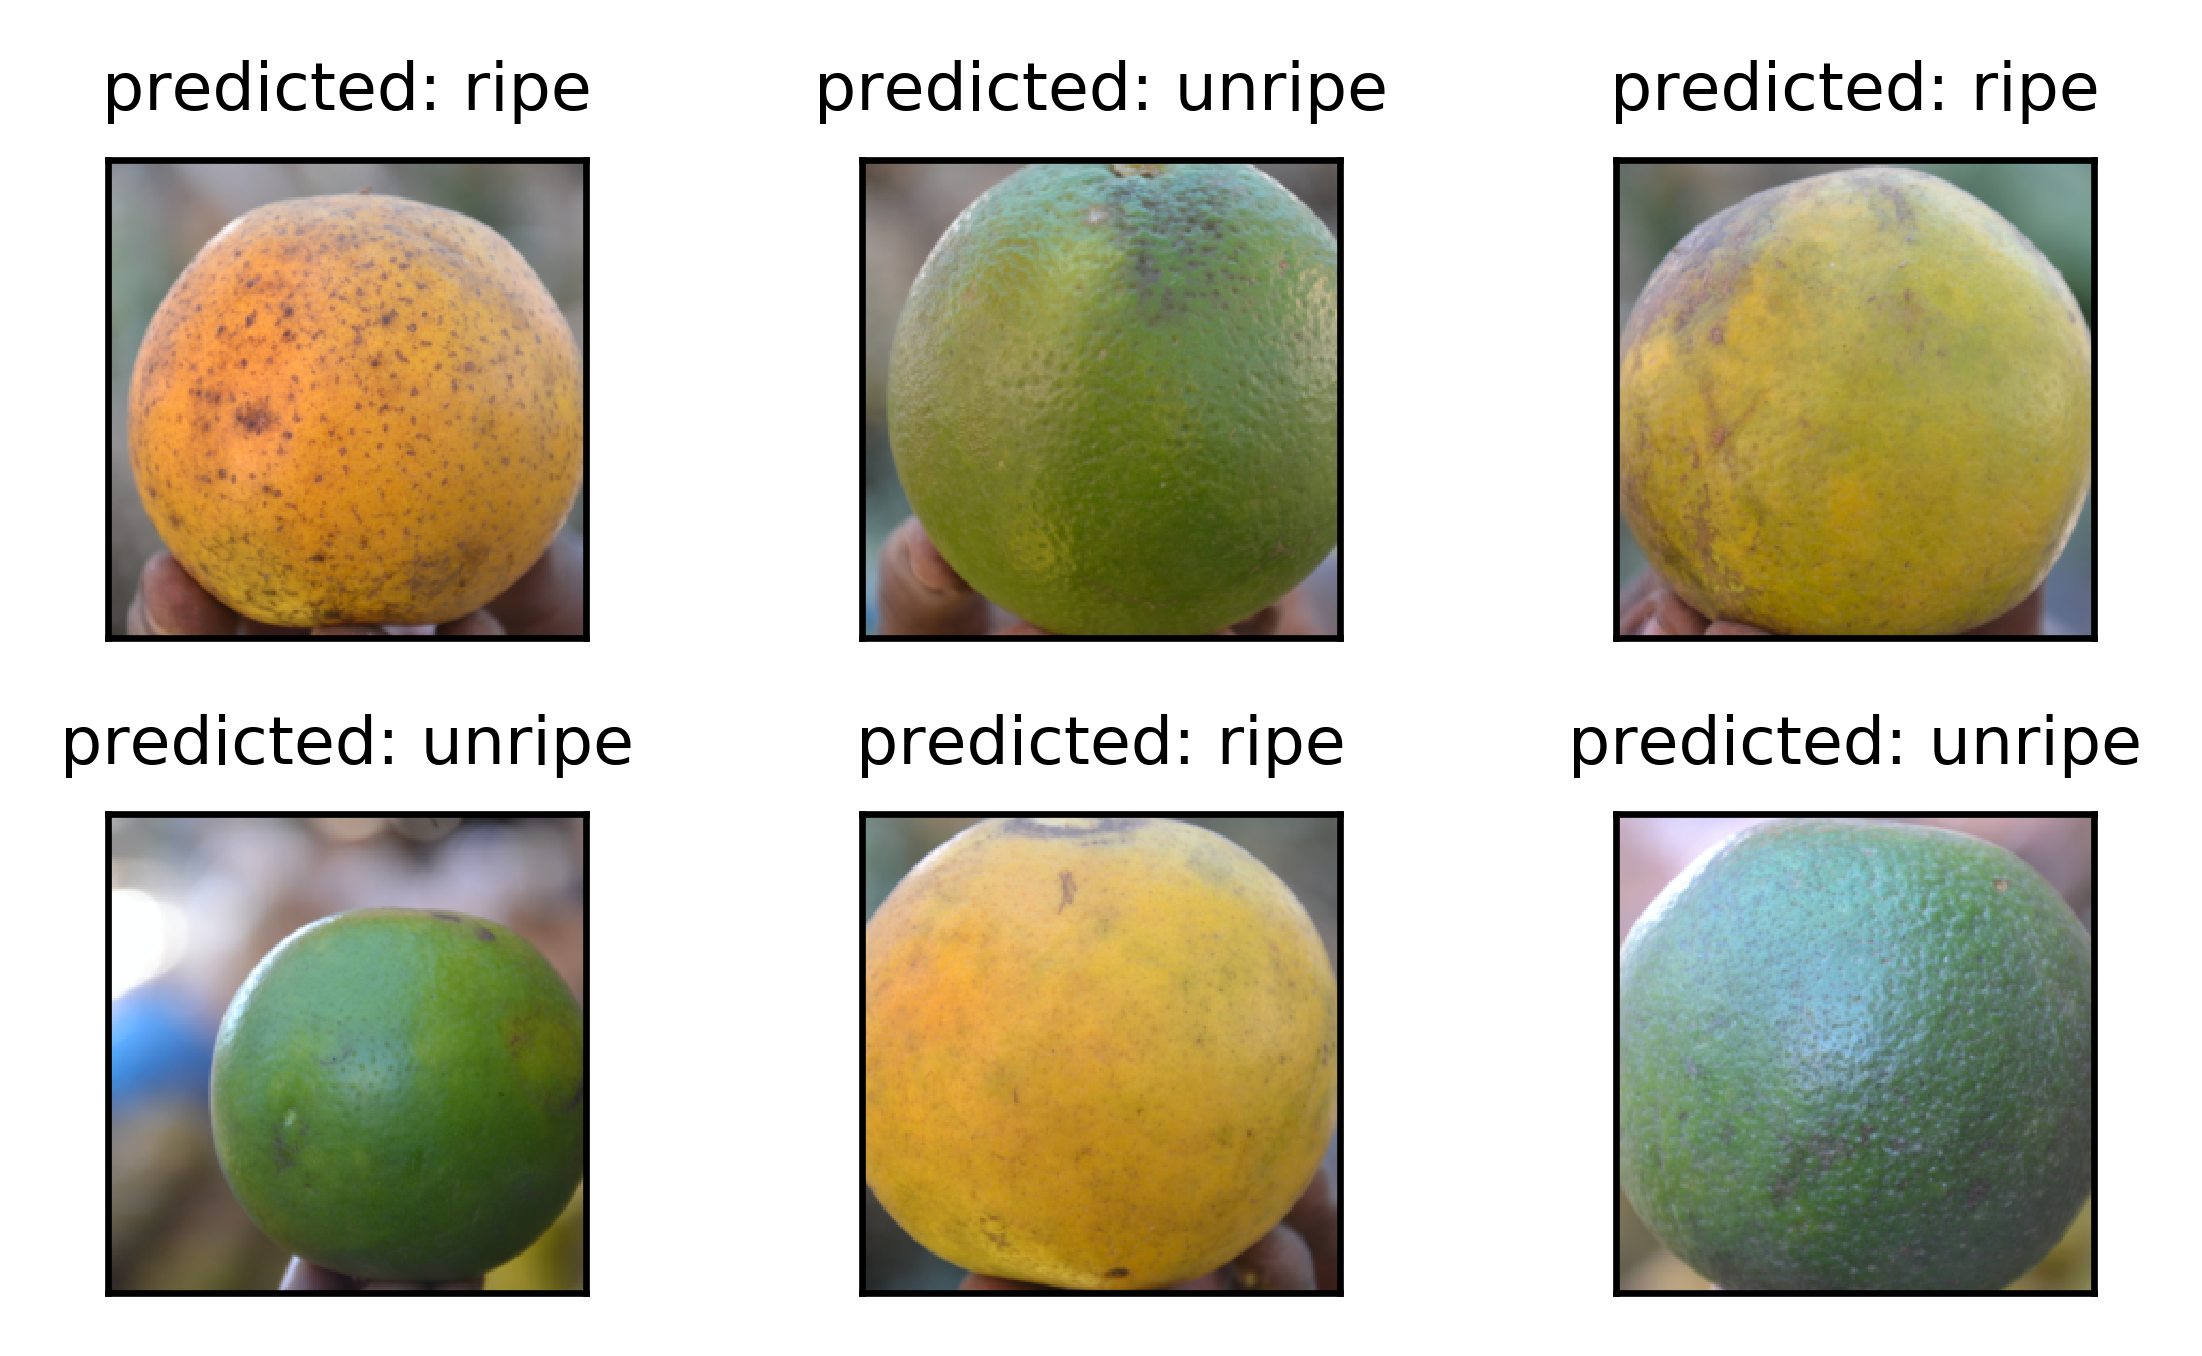

In [28]:
beatify(fig_width=4)
visualize_model(model_best)

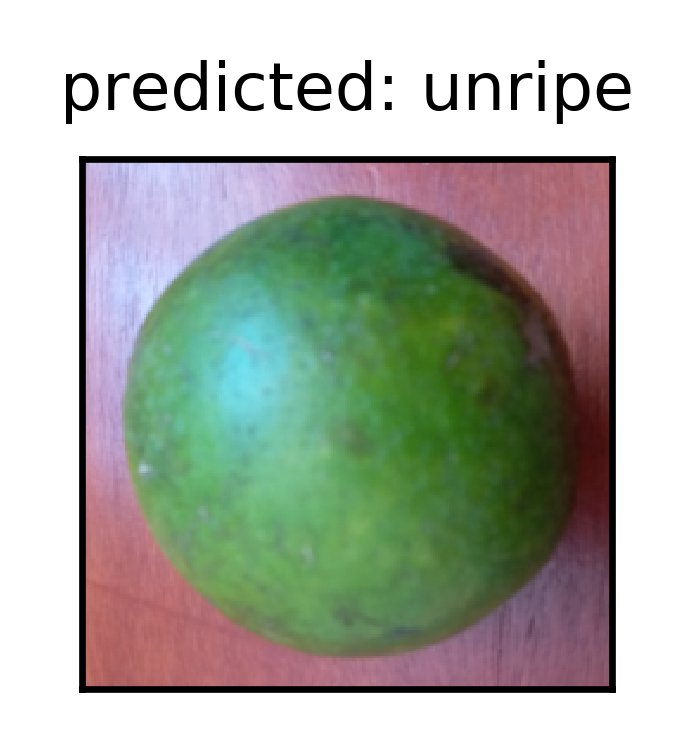

In [61]:
# print(dataloaders['val'][0])
transform = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),transform[x]) for x in ['test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=4) 
               for x in ['test']}

def test_model(model, num_images=1):

    training_mode = model.training
    model.eval()
    images_so_far = 0
    

    for i, data in enumerate(dataloaders['test']):
        
        inputs, labels = data
        
        #if torch.cuda.is_available():
            #inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        #else:
        inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            plt.subplot(2, 2, images_so_far)
            plt.imshow(inverse_transform(inputs.cpu().data[j]))
            plt.title('predicted: {}'.format(class_names[preds[j]]), fontsize=8)
            plt.tight_layout()
            plt.xticks([])
            plt.yticks([])
            #ax.axis('off')
    
            if images_so_far == num_images:
                model.train(mode=training_mode)
                return
    model.train(mode=training_mode)
    
test_model(model_best)